In [ ]:
!pip install transformers datasets yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datasets import load_dataset
from datetime import timedelta
import random
from transformers import pipeline

In [ ]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df_news = pd.DataFrame(dataset["train"])

In [ ]:
from datetime import timedelta
start_date = pd.to_datetime("2023-01-01")
df_news['date'] = [start_date + timedelta(days=random.randint(0, 364)) for _ in range(len(df_news))]

In [ ]:
label_map = {0: -1, 1: 0, 2: 1}
df_news["sentiment_score"] = df_news["label"].map(label_map)

In [ ]:
df_news.head()

,sentence,label,date,sentiment_score
0,"According to Gran , the company has no plans t...",1,2023-04-24,0
1,"For the last quarter of 2010 , Componenta 's n...",2,2023-10-01,1
2,"In the third quarter of 2010 , net sales incre...",2,2023-05-21,1
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,2023-09-16,1
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,2023-03-25,1


In [ ]:
daily_sentiments = df_news.groupby("date").agg({"sentiment_score": 'mean'}).reset_index()


In [ ]:
daily_sentiments.head()

,date,sentiment_score
0,2023-01-01,-0.125000
1,2023-01-02,-0.333333
2,2023-01-03,0.375000
3,2023-01-04,-0.333333
4,2023-01-05,0.250000


In [ ]:
finbert = pipeline("sentiment-analysis", model = "yiyanghkust/finbert-tone")

def analyze_sentiment(text):
  result = finbert(text)[0]['label']
  return {"Positive": 1, "Neutral": 0, "Negative": -1}.get(result, 0)

df_news["finbert_score"] = df_news["sentence"].apply(analyze_sentiment)


Device set to use cuda:0


In [ ]:
daily_finbert = df_news.groupby('date')['finbert_score'].mean().reset_index()
daily_finbert.columns = ['date', 'finbert_sentiment_score']


In [ ]:
stock_data = yf.download("MSFT", start="2023-01-01", end="2023-12-31")

if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = [' '.join(col).strip() for col in stock_data.columns.values]
print(stock_data.columns)
stock_data = stock_data[['Close MSFT']]  # Only use 'Close' price
stock_data = stock_data.reset_index()  # Make 'Date' a column

[*********************100%***********************]  1 of 1 completed

Index(['Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT'], dtype='object')


In [ ]:
# Merge with sentiment
daily_sentiments['date'] = pd.to_datetime(daily_sentiments['date'])  # Ensure datetime format
merged = pd.merge(stock_data, daily_sentiments, left_on='Date', right_on='date', how='left')

merged['label'] = merged['sentiment_score'].fillna(0)
merged['prev_close'] = merged['Close MSFT'].shift(1)
merged = merged.dropna()

merged = pd.merge(merged, daily_finbert, left_on='Date', right_on='date', how='left')
merged['finbert_sentiment_score'] = merged['finbert_sentiment_score'].fillna(0)

merged.head()

,Date,Close MSFT,date_x,sentiment_score,label,prev_close,date_y,finbert_sentiment_score
0,2023-01-04,224.949860,2023-01-04,-0.333333,-0.333333,235.240021,2023-01-04,-0.333333
1,2023-01-05,218.282883,2023-01-05,0.250000,0.250000,224.949860,2023-01-05,0.250000
2,2023-01-06,220.855423,2023-01-06,0.000000,0.000000,218.282883,2023-01-06,0.000000
3,2023-01-09,223.005737,2023-01-09,0.000000,0.000000,220.855423,2023-01-09,0.000000
4,2023-01-10,224.704407,2023-01-10,0.142857,0.142857,223.005737,2023-01-10,0.142857


In [ ]:
X = merged[['sentiment_score', 'prev_close', 'finbert_sentiment_score']]
# X = merged[['sentiment_score', 'prev_close']]
y = merged['Close MSFT']

split_index = int(0.8 * len(merged))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = model.predict(X_test)

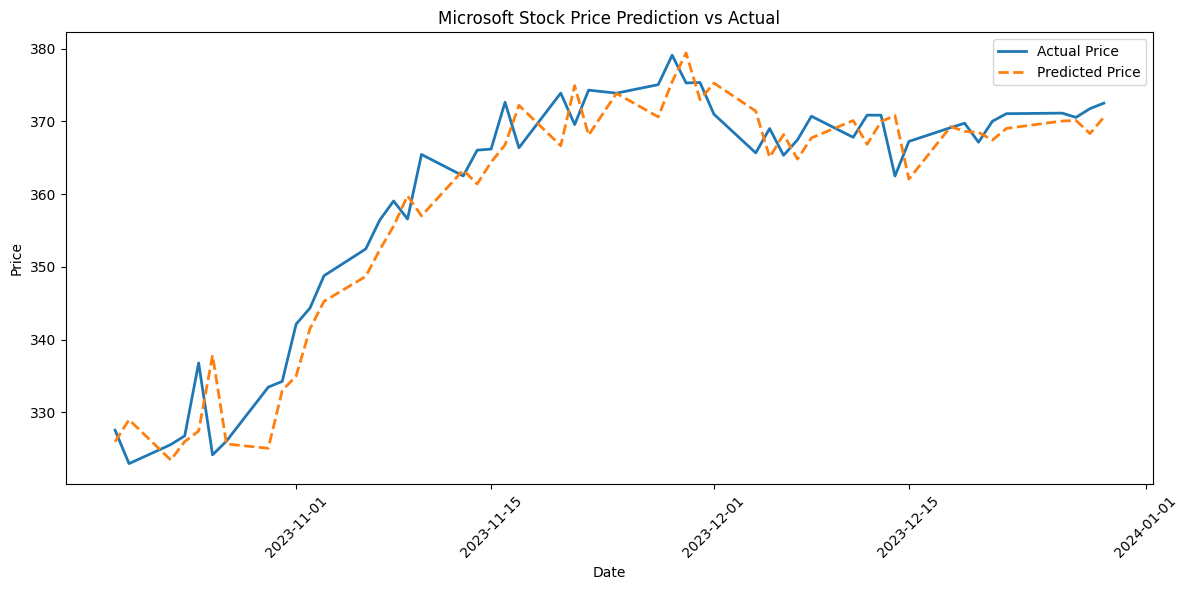

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(merged['Date'][split_index:], y_test.values, label='Actual Price', linewidth=2)

# Plot predicted prices
plt.plot(merged['Date'][split_index:], predictions, label='Predicted Price', linestyle='--', linewidth=2)


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Price Prediction vs Actual')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Computing the accuracy of the model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE:  3.79
MSE:  21.91
RMSE: 4.68
R² Score: 0.9198
